# CoCo Fatiando Terra Homework by Nicole Hucke

### Importing libraries and data

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray as xr
import pyproj

import pooch
import verde as vd
import boule as bl
import harmonica as hm

In [2]:
# Fetch Data from Alice Springs in Australia using Pooch

gravity_url = "https://raw.githubusercontent.com/santisoler/coco-fatiando-tutorial/main/homework_data/australia_gravity.csv"
gravity_hash = "sha256:b0f44e5b523a3ca034d07820022c23e5b65875956a88e6eda4cd69f9b66da9fc"

path_gravity = pooch.retrieve(gravity_url, known_hash=gravity_hash, progressbar=True)
path_gravity

# Download the Earth topography grid using Pooch

doi = "10.5281/zenodo.5167357"
topography_url = f"doi:{doi}/earth-topography-10arcmin.nc"
topography_hash = "md5:c43b61322e03669c4313ba3d9a58028d"

path_topography = pooch.retrieve(topography_url, known_hash=topography_hash, progressbar=True)
path_topography

'/home/jupyter-huck4481@vandals.u-5584a/.cache/pooch/cfd6d849435e1ca109cf31d2dae3fe32-earth-topography-10arcmin.nc'

In [3]:
# Load the Data

# Gravity Data
gravity = pd.read_csv(path_gravity)
gravity

,longitude,latitude,height,gravity
0,128.044657,-25.967222,506.670,978883.620
1,128.126386,-25.973100,520.380,978873.000
2,128.206151,-25.975900,527.905,978872.285
3,128.300509,-25.969732,545.220,978872.120
4,128.375399,-25.969807,559.490,978871.120
...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155
6583,135.710150,-20.037896,284.040,978562.595
6584,135.784400,-20.039506,281.255,978559.810
6585,135.878800,-20.037605,273.400,978552.690


In [4]:
# Topography Data

topography = xr.load_dataarray(path_topography)
topography

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

### Cropping to our site of interest

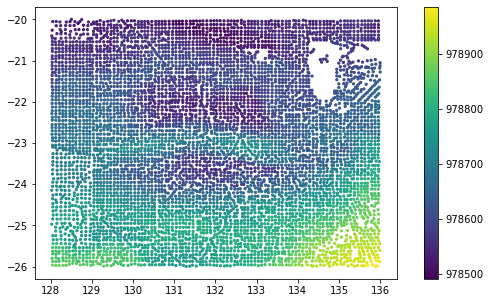

In [34]:
# Plot the data

fig = plt.figure(figsize=(10, 5))
plt.scatter(gravity.longitude, gravity.latitude, c=gravity.gravity, s=5)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.show()

In [15]:
# Crop the data to Alice Springs

region = vd.get_region((gravity.longitude, gravity.latitude))
region

(128.026316, 135.998461, -25.998477, -20.000249)

In [16]:
# Assign a padding value

region_pad = vd.pad_region(region, pad=5) 
region_pad

(123.02631600000001, 140.998461, -30.998477, -15.000249)

In [19]:
# Crop topography data to our site of interest + padding

topography = topography.sel(
    longitude=slice(region_pad[0], region_pad[1]),
    latitude=slice(region_pad[2], region_pad[3])
)
topography

<xarray.DataArray 'topography' (latitude: 95, longitude: 107)>
array([[369., 356., 326., ...,  54.,  67.,  67.],
       [353., 346., 329., ...,  45.,  64.,  69.],
       [343., 343., 337., ...,  36.,  58.,  71.],
       ...,
       [-14., -17., -27., ..., -24., -23., -21.],
       [-40., -31., -36., ..., -23., -22., -20.],
       [-65., -53., -51., ..., -30., -29., -27.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 123.2 123.3 123.5 123.7 ... 140.5 140.7 140.8
  * latitude   (latitude) float64 -30.83 -30.67 -30.5 ... -15.5 -15.33 -15.17
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

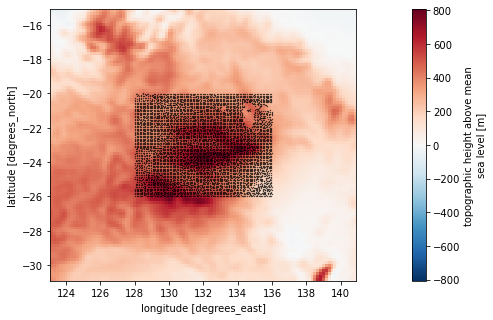

In [50]:
# Plot gravity and topography data

plt.figure(figsize=(20, 5))
topography.plot()
plt.scatter(gravity.longitude, gravity.latitude, c="black", s=0.1)
plt.gca().set_aspect("equal")
plt.show()

### Grid Projection

In [53]:
# Project the data and the grid

projection = pyproj.Proj(proj="merc", lat_ts=gravity.latitude.mean())

# Transform the gravity data coordinates to Mercator and then include them in the data frame

easting, northing = projection(gravity.longitude.values, gravity.latitude.values)
gravity = gravity.assign(easting_m=easting, northing_m=northing) # agregando columnas para tener las coordenadas de easting y northing 
gravity

,longitude,latitude,height,gravity,easting_m,northing_m
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06
...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06


In [54]:
# Grid projection interpolation: we chose nearest neighbor method because of how fast and efficient it is 

topography_proj = vd.project_grid(topography, projection, method="nearest")
topography_proj

<xarray.DataArray 'topography' (northing: 95, easting: 107)>
array([[369. , 356. , 326. , ...,  60.5,  60.5,  67. ],
       [353. , 346. , 329. , ...,  54.5,  54.5,  69. ],
       [343. , 343. , 337. , ...,  47. ,  47. ,  71. ],
       ...,
       [-14. , -17. , -27. , ..., -23.5, -23.5, -21. ],
       [-52.5, -42. , -43.5, ..., -26. , -26. , -23.5],
       [-52.5, -42. , -43.5, ..., -26. , -26. , -23.5]], dtype=float32)
Coordinates:
  * easting   (easting) float64 1.262e+07 1.264e+07 ... 1.442e+07 1.444e+07
  * northing  (northing) float64 -3.305e+06 -3.286e+06 ... -1.581e+06 -1.563e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

### Calculating Gravity Disturbance

In [55]:
# Defining reference elipsoid 
ellipsoid = bl.WGS84
ellipsoid

Ellipsoid(name='WGS84', semimajor_axis=6378137, flattening=0.0033528106647474805, geocentric_grav_const=398600441800000.0, angular_velocity=7.292115e-05, long_name='World Geodetic System 1984', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')

In [59]:
# Calculating normal gravity over observation points

normal_gravity = ellipsoid.normal_gravity(gravity.latitude, gravity.height) 
normal_gravity

0       978866.840808
1       978863.027394
2       978860.904068
3       978855.121930
4       978850.723320
            ...      
6582    978549.228405
6583    978551.324071
6584    978552.277270
6585    978554.591637
6586    978554.854833
Length: 6587, dtype: float64

In [60]:
# Calculate gravity disturbance and add to the data frame

gravity_disturbance = gravity.gravity - normal_gravity # using the formula provided in the tutorial

gravity = gravity.assign(gravity_disturbance_mgal=gravity_disturbance) # adding to data frame
gravity

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06,16.779192
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06,9.972606
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06,11.380932
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06,16.998070
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06,20.396680
...,...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06,9.926595
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06,11.270929
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06,7.532730
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06,-1.901637


In [61]:
# Creating a function for plotting the gravity disturbance

def scatter_plot_gravity(easting, northing, gravity_data, title=None):
    """
    Generate scatter plots of gravity data
    
    The colorbar will be centered around cero and using the seismic colormap.
    
    Parameters
    ----------
    easting: array
        Easting coordinates of the gravity data in meters.
    northing : array
        Northing coordinates of the gravity data in meters.
    gravity_data : array
        Values of the gravity data in mgal.
    title : str (optional)
        Title of the plot.
    """
    maxabs = vd.maxabs(gravity_data)
    plt.figure(figsize=(12, 12))
    plt.scatter(
        easting,
        northing,
        c=gravity_data,
        s=10,
        cmap="seismic",
        vmin=-maxabs,
        vmax=maxabs,
    )
    plt.xlabel("easting [m]")
    plt.ylabel("northing [m]")
    if title is not None:
        plt.title(title)
    plt.colorbar(label="mGal", shrink=0.6)
    plt.gca().set_aspect("equal")

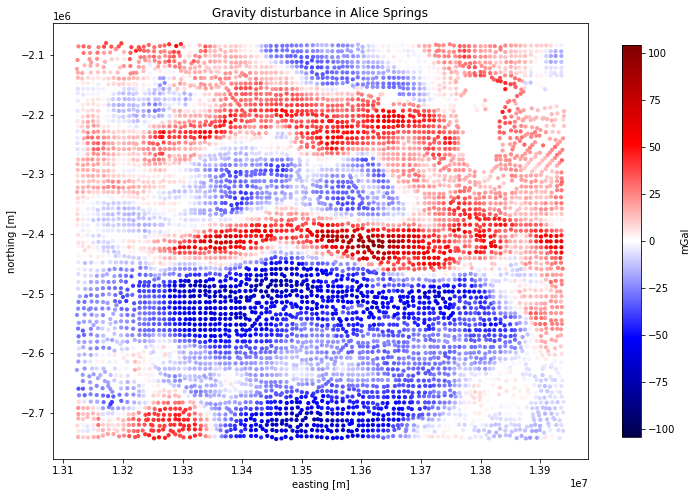

In [62]:
# Plot the gravity disturbance in our site of interest 

scatter_plot_gravity(
    gravity.easting_m,
    gravity.northing_m,
    gravity.gravity_disturbance_mgal,
    title="Gravity disturbance in Alice Springs",
)

### Topographic Correction 

In [64]:
# Assigning densities to the prisms 
density = np.where(topography_proj > 0, 2670, 1040 - 2670)

# Obtaining topography model using harmonica 
topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": density},
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 95, easting: 107)
Coordinates:
  * easting   (easting) float64 1.262e+07 1.264e+07 ... 1.442e+07 1.444e+07
  * northing  (northing) float64 -3.305e+06 -3.286e+06 ... -1.581e+06 -1.563e+06
    top       (northing, easting) float32 369.0 356.0 326.0 ... 0.0 0.0 0.0
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... -26.0 -26.0 -23.5
Data variables:
    density   (northing, easting) int64 2670 2670 2670 ... -1630 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

In [66]:
# Calculate the gravity effect of these prisms

coordinates = (gravity.easting_m, gravity.northing_m, gravity.height)

terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z") # Prism layer method, we are calculating the gravity effect
terrain_effect # Gravity effect of every prism point at different densities (3D)

array([54.66501982, 57.75299477, 58.67764679, ..., 27.41796757,
       27.41603452, 27.52748475])

In [67]:
# Adding it to our data frame
gravity = gravity.assign(terrain_effect_mgal=terrain_effect) 
gravity

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06,16.779192,54.665020
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06,9.972606,57.752995
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06,11.380932,58.677647
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06,16.998070,60.124957
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06,20.396680,61.868187
...,...,...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06,9.926595,28.310207
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06,11.270929,28.308433
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06,7.532730,27.417968
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06,-1.901637,27.416035


In [70]:
# Calculating Bouguer gravity disturbance (The gravity disturbance without the effect of topography)
gravity_bouguer = gravity.gravity_disturbance_mgal - gravity.terrain_effect_mgal 

gravity = gravity.assign(gravity_bouguer_mgal=gravity_bouguer)
gravity

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06,16.779192,54.665020,-37.885828
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06,9.972606,57.752995,-47.780389
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06,11.380932,58.677647,-47.296715
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06,16.998070,60.124957,-43.126886
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06,20.396680,61.868187,-41.471507
...,...,...,...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06,9.926595,28.310207,-18.383612
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06,11.270929,28.308433,-17.037504
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06,7.532730,27.417968,-19.885238
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06,-1.901637,27.416035,-29.317672


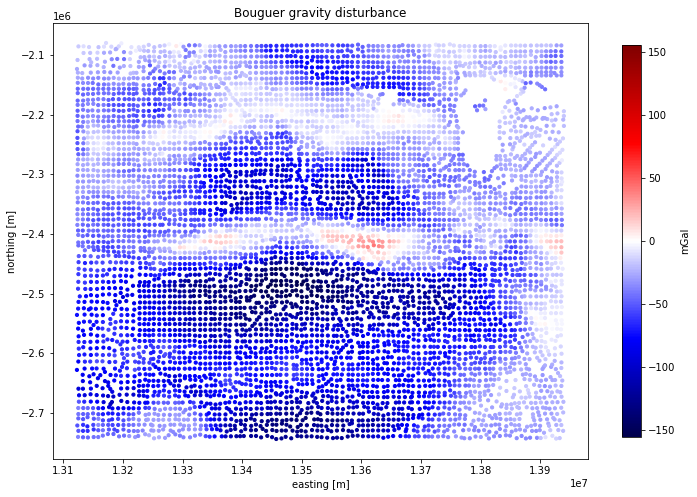

In [72]:
# Plotting the Bouger gravity disturbance 
scatter_plot_gravity(
    gravity.easting_m,
    gravity.northing_m,
    gravity.gravity_bouguer_mgal,
    title="Bouguer gravity disturbance",
)

### Regional-residual separation

In [76]:
#To observe the signal from igneous bodies, we will be using the equivalent source technique from Harmonica

# Define the equivalent sources located at 500 km depth
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3) # Assume damping parameter =1000

In [77]:
# Adjust their masses in such a way that they generate a field approximately equal to that of the Bouguer disturbance

# We fit the deep sources using the Bouguer gravity disturbance values:
coordinates = (gravity.easting_m, gravity.northing_m, gravity.height)

deep_sources.fit(coordinates, gravity.gravity_bouguer_mgal)

/opt/tljh/user/envs/coco-projects/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=1000, depth=500000.0)

In [79]:
#Calculate the regional effect as the effect generated by these sources in the observation points

gravity_regional = deep_sources.predict(coordinates)

gravity = gravity.assign(gravity_regional_mgal=gravity_regional)
gravity

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06,16.779192,54.665020,-37.885828,-48.035297
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06,9.972606,57.752995,-47.780389,-48.794558
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06,11.380932,58.677647,-47.296715,-49.593353
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06,16.998070,60.124957,-43.126886,-50.689460
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06,20.396680,61.868187,-41.471507,-51.519062
...,...,...,...,...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06,9.926595,28.310207,-18.383612,-24.654067
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06,11.270929,28.308433,-17.037504,-24.260547
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06,7.532730,27.417968,-19.885238,-23.885082
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06,-1.901637,27.416035,-29.317672,-23.437668


In [81]:
# Calculating the residual effect by subtracting the regional effect from the Bouguer gravity disturbance
gravity_residual = gravity.gravity_bouguer_mgal - gravity_regional

gravity = gravity.assign(gravity_residual_mgal=gravity_residual)
gravity

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal,gravity_residual_mgal
0,128.044657,-25.967222,506.670,978883.620,1.312457e+07,-2.740512e+06,16.779192,54.665020,-37.885828,-48.035297,10.149469
1,128.126386,-25.973100,520.380,978873.000,1.313295e+07,-2.741179e+06,9.972606,57.752995,-47.780389,-48.794558,1.014169
2,128.206151,-25.975900,527.905,978872.285,1.314112e+07,-2.741496e+06,11.380932,58.677647,-47.296715,-49.593353,2.296639
3,128.300509,-25.969732,545.220,978872.120,1.315079e+07,-2.740797e+06,16.998070,60.124957,-43.126886,-50.689460,7.562574
4,128.375399,-25.969807,559.490,978871.120,1.315847e+07,-2.740805e+06,20.396680,61.868187,-41.471507,-51.519062,10.047554
...,...,...,...,...,...,...,...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155,1.390209e+07,-2.083703e+06,9.926595,28.310207,-18.383612,-24.654067,6.270455
6583,135.710150,-20.037896,284.040,978562.595,1.391028e+07,-2.083604e+06,11.270929,28.308433,-17.037504,-24.260547,7.223044
6584,135.784400,-20.039506,281.255,978559.810,1.391789e+07,-2.083779e+06,7.532730,27.417968,-19.885238,-23.885082,3.999844
6585,135.878800,-20.037605,273.400,978552.690,1.392757e+07,-2.083573e+06,-1.901637,27.416035,-29.317672,-23.437668,-5.880004


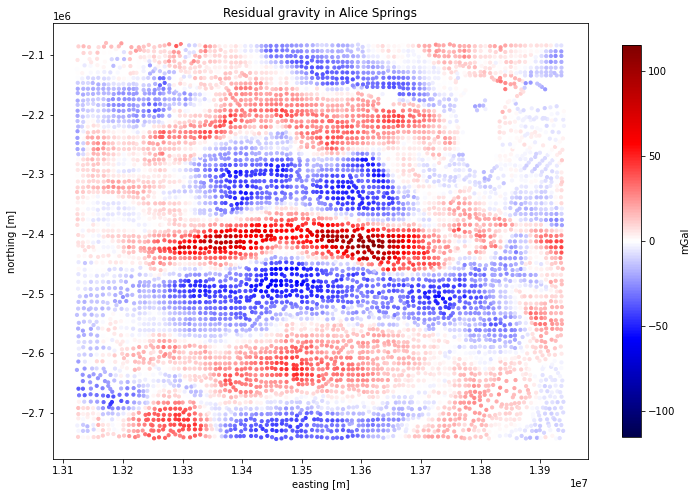

In [83]:
# Plot the residual gravity field
scatter_plot_gravity(
    gravity.easting_m,
    gravity.northing_m,
    gravity.gravity_residual_mgal,
    title="Residual gravity in Alice Springs",
)

### Grid the residuals

In [84]:
# Defining the equivalent sources located at a depth of 10km and with a damping of 10
eqs = hm.EquivalentSources(damping=10, depth=10e3)

coordinates = (gravity.easting_m, gravity.northing_m, gravity.height)
eqs.fit(coordinates, gravity.gravity_residual_mgal)

/opt/tljh/user/envs/coco-projects/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=10, depth=10000.0)

In [85]:
# Calculate the effect of the sources on a regular grid at 2200 meters altitude, with a resolution of 2 arc minutes
residual_grid = eqs.grid(
    upward=2200,  # height in meters
    spacing=3000,  # spacing in meters
    data_names=["gravity_residual"],
)
residual_grid

<xarray.Dataset>
Dimensions:           (northing: 223, easting: 273)
Coordinates:
  * easting           (easting) float64 1.312e+07 1.313e+07 ... 1.394e+07
  * northing          (northing) float64 -2.744e+06 -2.741e+06 ... -2.08e+06
    upward            (northing, easting) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual  (northing, easting) float64 8.191 7.484 ... -4.711 -5.114
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

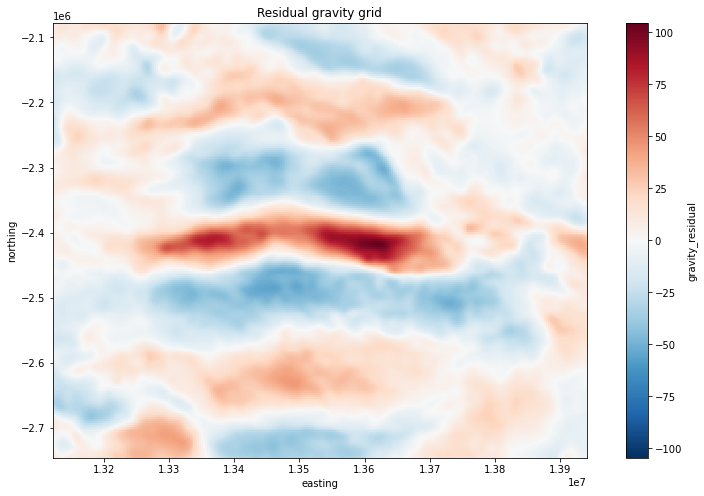

In [95]:
# Plot the grid 
plt.figure(figsize=(14, 8))
residual_grid.gravity_residual.plot()
plt.title("Residual gravity grid")
plt.gca().set_aspect("equal")
plt.show()